# Alejandro Cano Moya

## Proyecto de programación "*Pattern Recognition*"

## Premisa

En esta actividad, se va a utilizar técnicas de reconocimiento de patrones de imagen para detectar si una célula es cancerígena.


#### Cargar una de las imágenes histológicas

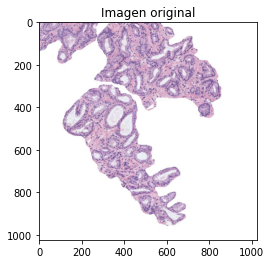

In [1]:
# Utiliza la librería skimage.io para leer la imagen 'histo_x.jpg' y visualízala usando la librería de matplotlib.
# Recuerda normalizar la imagen diviéndola entre 255
import skimage.io as io
import matplotlib.pyplot as plt

#img = io.imread(fname="images/histo_1.jpg")
img = io.imread(fname="images/histo_2.jpg")
img_norm = img/255

plt.imshow(img_norm)
plt.title("Imagen original")
plt.show()


#### Realizar una transformación de color para convertir la imagen al espacio de color CMYK

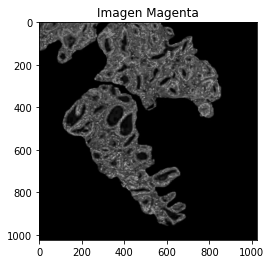

True

In [2]:
# 1) Extrae la componente magenta de la imagen (que corresponde a la región tisular)
# 2) Visualiza la imagen con la librería de matplotlib. 
# 3) Guarda la imagen Magenta con cv2.imwrite con el nombre "1_imagen_magenta.png"
import numpy as np
import cv2

with np.errstate(invalid='ignore', divide='ignore'):
    K = 1 - np.max(img_norm, axis=2)
    C = (1-img_norm[...,2] - K)/(1-K)
    M = (1-img_norm[...,1] - K)/(1-K)
    Y = (1-img_norm[...,0] - K)/(1-K)

CMYK = 255*(np.dstack((C,M,Y,K)))
C,M,Y,K = cv2.split(CMYK)

plt.imshow(M, cmap='gray')
plt.title("Imagen Magenta")
plt.show()

cv2.imwrite("images/1_imagen_magenta.png",M)

#### Umbralizar la imagen para separar los píxeles del fondo de la región tisular

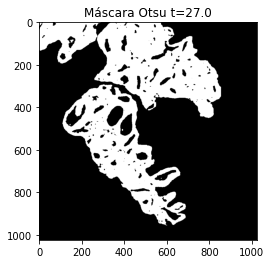

True

In [3]:
# 1) Convierte la imagen Magenta a formato "uint8"
# 2) Aplica un filtro gaussiano de tamaño 5x5
# 3) Umbraliza la imagen aplicando el método de Otsu
# 4) Aplica el umbral de manera que los píxeles del fondo y de los lúmenes sean 1s y el resto 0s. 
# 5) Visualiza la máscara resultante (imagen de 0s y 1s)
# 6) Guarda la máscara multiplicándola por 255 con el nombre "2_mascara_con_artefactos.png"

M = M.astype('uint8')
# Aplicamos filtro gaussiano
img_gaus = cv2.GaussianBlur(M, (5,5), 0)
# Fijamos el umbral con el método de OTSU
t, mask = cv2.threshold(img_gaus,0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU) # 0 es por defecto y 1 es el valor máximo de la máscara
# Visualizamos para corroborar que se obtiene el mismo resultado
plt.imshow(mask, cmap='gray')
plt.title('Máscara Otsu t=' + str(t))
plt.show()

cv2.imwrite("images/2_mascara_con_artefactos.png",mask*255)

#### Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

<ipython-input-4-3c7abf95de76>:9: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  img_small_removed =  morphology.remove_small_objects(mask, 300, 8)
<ipython-input-4-3c7abf95de76>:10: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  img_small_removed =  morphology.remove_small_holes(img_small_removed, 300, 8).astype('uint8')


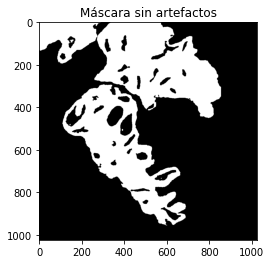

True

In [4]:
# 1) Utiliza la librería skimage.morphology.remove_small_objects. 
# Lee la documentación en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Fija el umbral en 300 píxeles y la conectividad del objeto en 8 píxeles.
# 2) Convierte la máscara generada en formato uint8
# 3) Visualiza la máscara resultante
# 4) Guarda la máscara multiplicándola por 255 con el nombre "3_mascara_sin_artefactos.png"
from skimage import morphology

img_small_removed =  morphology.remove_small_objects(mask, 300, 8)
img_small_removed =  morphology.remove_small_holes(img_small_removed, 300, 8).astype('uint8')

plt.imshow(img_small_removed, cmap='gray')
plt.title('Máscara sin artefactos')
plt.show()

cv2.imwrite("images/3_mascara_sin_artefactos.png",img_small_removed*255)

#### Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

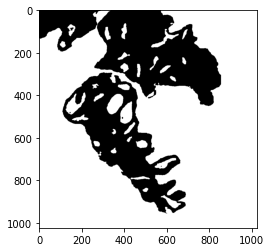

In [5]:
# 1) Invierte la máscara anterior para que el fondo y los lúmenes sean negros y el resto de píxeles blancos
img_inv = cv2.bitwise_not(img_small_removed*255)

plt.imshow(img_inv, cmap='gray')
plt.show()


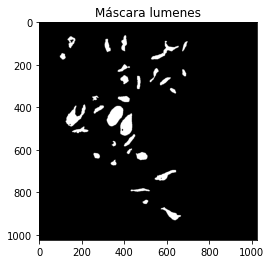

True

In [6]:
# 2) Aplica el algoritmo de expansión a partir de semillas
# Pon dos semillas: una en la esquina superior izquierda y otra en la esquina inferior derecha.
# 3) Visualiza la máscara resultante
# 4) Guarda la máscara multiplicándola por 255 con el nombre "4_mascara_lumenes.png"

canny = img_inv.copy()
h, w = canny.shape
ref = np.zeros((h+2, w+2), np.uint8)
# Se fija la semilla en la esquina superior izquierda e inferior derecha para rellenar a partir de ahí
cv2.floodFill(canny, ref, (0,0), 0)
cv2.floodFill(canny, ref, (1023,1023), 0)
# Se calcula el inverso del rellenado para obtener la máscara deseada
mask_lumens = canny.astype('uint8')

plt.imshow(mask_lumens, cmap='gray')
plt.title('Máscara lumenes')
plt.show()

cv2.imwrite("images/4_mascara_lumenes.png",mask_lumens)


#### Rellenar los objetos de los lúmenes

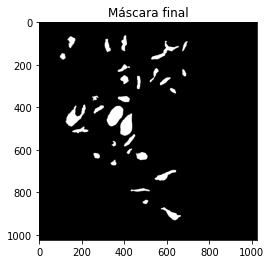

True

In [7]:
# 1) Rellena los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# 2) Convierte la máscara resultante en formato uint8
# 3) Visualiza la máscara
# 4) Guarda la máscara multiplicándola por 255 con el nombre "5_mascara_final.png"
from scipy import ndimage

final_mask = ndimage.binary_fill_holes(mask_lumens)
final_mask = final_mask.astype('uint8')

plt.imshow(final_mask, cmap='gray')
plt.title('Máscara final')
plt.show()

cv2.imwrite("images/5_mascara_final.png",final_mask*255)

#### Detectar y dibujar los contornos de los lúmenes sobre la imagen original

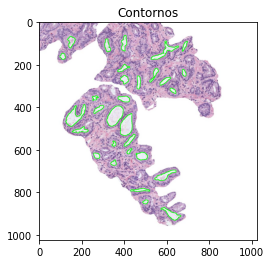

True

In [8]:
# 1) Encuentra los contornos de los lúmenes
# 2) Dibuja los contornos (de color verde) sobre la imagen original
# 3) Visualiza la imagen superpuesta
# 4) Guarda la imagen multiplicándola por 255 con el nombre "6_imagen_superpuesta.png"
img_copy = img.copy()

contours, _ = cv2.findContours(final_mask.astype('uint8')*255, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

img_copy = cv2.drawContours(img_copy, contours, -1, (0, 255, 0), 2)

plt.imshow(img_copy, cmap='gray')
plt.title('Contornos')
plt.show()

cv2.imwrite('images/6_imagen_superpuesta.png',cv2.cvtColor(img_copy, cv2.COLOR_RGB2BGR))


#### Identificar y cropear el lumen más grande

número de objetos:  30
posibles valores de intensidad:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]


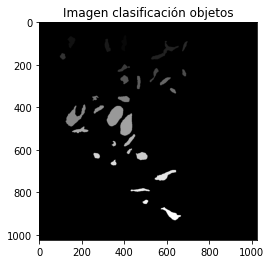

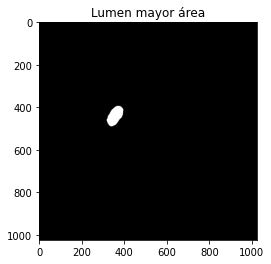

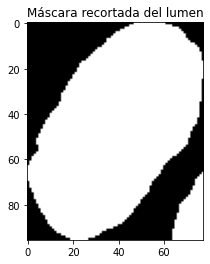

True

In [9]:
# 1) Convierte la máscara de lúmenes en una imagen de etiquetas utilizando la librería skimage.measure
from skimage.measure import label

lab, num = label(final_mask, return_num=True)

print('número de objetos: ', num)
v,c = np.unique(lab, return_counts=True)
print('posibles valores de intensidad: ', v)

plt.imshow(lab, cmap='gray')
plt.title('Imagen clasificación objetos')
plt.show()

# 2) Calcula el área de cada uno de los lúmenes
from skimage.measure import regionprops

area_val = 0
list_areas = []

for i in range (1, num+1):
    objeto = lab == i
    prop = regionprops(objeto.astype(np.uint8))
    area = np.round(prop[0].area, 4)
    list_areas.append(area)
    if area > area_val:
        objeto_final = lab == i
        area_val = area

# 3) Obtén una máscara del lumen de mayor área
objeto = objeto_final.astype('uint8')

plt.imshow(objeto, cmap='gray')
plt.title('Lumen mayor área')
plt.show()

# 4) Haz un crop (recorte) del lumen de mayor área utilizando las coordenadas de la bounding box
prop = regionprops(objeto)
bbox = prop[0].bbox
start_point = (bbox[1], bbox[0])
end_point = (bbox[3], bbox[2])

crop = final_mask[bbox[0]:bbox[2],bbox[1]:bbox[3]]

# 5) Visualiza la máscara recortada del lumen                     
plt.imshow(crop, cmap='gray')
plt.title('Máscara recortada del lumen')
plt.show()


# 6) Guarda la imagen multiplicándola por 255 con el nombre "7_crop_image.png"
# Convertimos la imagen binaria en una imagen de etiquetas para tener acceso a cada objeto por separado
cv2.imwrite("images/7_crop_image.png",crop*255)


#### Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [10]:
# Calcula las siguientes características del crop del lumen anterior, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Longitud del eje mayor
# 8) Longitud del eje menor
# 9) Orientación
# 10) Perímetro
# 11) Solidez
# 12) Compacidad
# 13) Rectangularidad
from tabulate import tabulate
import math

headers = ['','Lumen']
A,BB,CA,E,ED,EX,MA,MiA,O,P,S,CO,R = ['area'], ['bbox_area'], ['convex_area'], ['eccentricity'], ['equiv_diameter'], \
['extent'], ['major_axis'], ['minor_axis'], ['orientation'], ['perimeter'], ['solidity'], ['compactness'], ['rectangularity']


objeto = objeto_final
prop = regionprops(objeto.astype(np.uint8))

A.append(np.round(prop[0].area, 4))
BB.append(np.round(prop[0].bbox_area, 4))
CA.append(np.round(prop[0].convex_area, 4))
E.append(np.round(prop[0].eccentricity, 4))
ED.append(np.round(prop[0].equivalent_diameter, 4))
EX.append(np.round(prop[0].extent, 4))
MA.append(np.round(prop[0].major_axis_length, 4))
MiA.append(np.round(prop[0].minor_axis_length, 4))
O.append(np.round(prop[0].orientation, 4))
P.append(np.round(prop[0].perimeter, 4))
S.append(np.round(prop[0].solidity, 4))

CO.append(np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4))
R.append(np.round(prop[0].area/prop[0].bbox_area, 4))


my_data = [tuple(A), tuple(BB), tuple(CA), tuple(E), tuple(ED), tuple(EX), \
          tuple(MA), tuple(MiA), tuple(O), tuple(P), tuple(S), tuple(CO), tuple(R)]

print(tabulate(my_data, headers=headers))



                    Lumen
--------------  ---------
area            4887
bbox_area       7488
convex_area     5020
eccentricity       0.8355
equiv_diameter    78.8817
extent             0.6526
major_axis       106.646
minor_axis        58.5958
orientation       -0.5612
perimeter        280.392
solidity           0.9735
compactness        0.7811
rectangularity     0.6526
